In [2]:
#Reads in, merges and filters several catalogs of data
#Manipulates data set to create features relevent to data analysis and visualization
#Version of catalog merging program merging with added NUV-R vs R-J plot after addition of L_TIR data
#The original binning tests and data analysis are the Rotate_PreGordo_cat_all_rev4 notebook
#Because I received L_TIR data last-minute I am doing the merge and analysis in the same notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as py
import sys,os
%pylab inline
#Cluster_tools is folder containing many functions for filtering and cosmological calculations
import cluster_tools.CAT as CAT
import cluster_tools.tools as tools
import cluster_tools.cosmo as cosmos
import cluster_tools.Cluster_functs as t
#reload(t) 
import pickle
import cluster_tools.CalcVelDisp_bcl_edit as v
import scipy.integrate
import mpld3
from IPython.display import Image, display

3!= 6.0 = e^(ln[gamma(4)]) = 6
120.0
4.03291461127e+26
24.0
0.994376487882
0.00562351211827
1.0
0.112754082424
0.520357177501
0.842681743299
0.999999999998
-0.112754082424
-0.520357177501
-0.842681743299
-0.999999999998
36.4981663726
0.999329074744


In [3]:
#Reads in several catalogs of different formats that need to be merged and filtered before analysis
filepath='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cat_git_worked/'
filepatho='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/'
cat_g=pd.read_csv(filepath+'cl0910+5422_v0.0.3.crossmatch',sep='\s+')
cat_mag=pd.read_csv(filepath+'cl0910+5422_v0.0.3.mag',sep='\s+')
cat_pz=pd.read_csv(filepath+'cl0910+5422_v0.0.3.zout',sep='\s+')
cat_pzb=pd.read_csv(filepath+'rxj0910.P_inclus.dat',sep='\s+',header=None) 
cat_uvb=pd.read_csv(filepath+'cl0910+5422_v0.0.3.restframe',sep='\s+')
cat_uvb['z_uvb']=cat_uvb['z']
cat_uvb.drop('z',axis=1,inplace=True)
fout=['id','ltau','metal','lage','Av','lmass','lsfr','lssfr','la2t','l68_lmass','u68_lmass','l68_lsfr','u68_lsfr','l68_lssfr','u68_lssfr']
zout=['id','z_peak','l68','u68','l95','u95','dds']
cat_fir=pd.read_csv(filepath+'cl0910+5422_v0.0.3.fir',sep='\s+')
firout=['id', 'ftot_mips24', 'etot_mips24', 'weight_mips24', 'LIR', 'L2800', 'SFR_UVIR']
cat_fout=pd.read_csv(filepath+'cl0910+5422_v0.0.3.fout',sep='\s+')
#regex because crossmatch catalog has weird formatting
cat_o=pd.read_csv(filepatho+'FINAL.spectroscopic.autocompile.blemaux.sc0910.feb2016.plusT08.nodups.cat',sep=r'\s+|\t|[ ]{2,}')
cat_g=cat_g.merge(cat_o[['id_spec','old_id','slit','maskname','comments']],on=['id_spec','slit','maskname'],how='outer')
cat_mag.set_index('id',drop=False,inplace=True) #Need to match this to crossmatch for specids, inner
cat_pz.set_index('id',drop=False,inplace=True)
cat_fir.set_index('id',drop=False,inplace=True)
cat_fout.set_index('id',drop=False,inplace=True)
cat_uvb.set_index('id',drop=False,inplace=True)
cat_pzb.reset_index(inplace=True)
cat_pzb.columns=['id','pzcdf']
cat_pzb['id']=cat_pzb['id']+1
cat_pzb.set_index('id',drop=False,inplace=True)
#magnitude photometric corrections and error propagation
cat_mag['I']=cat_mag.magaper_Iplus + cat_mag.apercorr #There are lots of inf values with use=1...? not -99
cat_mag['R']=cat_mag.magaper_Rc + cat_mag.apercorr
cat_mag['Z']=cat_mag.magaper_Zplus + cat_mag.apercorr
cat_mag['J']=cat_mag.magaper_J + cat_mag.apercorr
cat_mag['K']=cat_mag.magaper_K + cat_mag.apercorr
cat_mag['B']=cat_mag.magaper_B + cat_mag.apercorr
cat_mag['Berr']=cat_mag.erraper_B
cat_mag['Jerr']=cat_mag.erraper_J
cat_mag['Kerr']=cat_mag.erraper_K
#Errors sig(a+x)=sqrt( 1* sig(x)**2 + 1*sig(a)**2 ) 
cat_mag['Ierr']=cat_mag.erraper_Iplus
cat_mag['Rerr']=cat_mag.erraper_Rc
cat_mag['Zerr']=cat_mag.erraper_Zplus
cat_mag['IZ']=cat_mag['I']-cat_mag['Z']
cat_mag['RZ']=cat_mag['R']-cat_mag['Z']
cat_mag['RI']=cat_mag['R']-cat_mag['I']
cat_mag['RIerr']=np.sqrt( cat_mag['Rerr']**2 + cat_mag['Ierr']**2 )
cat_mag['IZerr']=np.sqrt( cat_mag['Ierr']**2 + cat_mag['Zerr']**2 )
cat_mag['RZerr']=np.sqrt( cat_mag['Rerr']**2 + cat_mag['Zerr']**2 )
cat_mpz=cat_mag.merge(cat_pz[['id','z_peak','z_spec']],how='outer',left_index=True,right_index=True,on='id',suffixes=('_mag','_zout'))
cat_mpz=cat_mpz.merge(cat_pzb, how='outer',left_index=True,right_index=True,on='id')
cat_mpz=cat_mpz.merge(cat_uvb, how='outer',left_index=True,right_index=True,on='id')
cat_mpz=cat_mpz.merge(cat_fout[fout],how='outer',left_index=True,right_index=True,on='id',suffixes=('_mag','_fout'))
cat_mpz=cat_mpz.merge(cat_fir[firout],how='outer',left_index=True,right_index=True,on='id')
cat_mpz=cat_mpz[cat_mpz.use==1] 
cat_mpz['id_phot']=cat_mpz['id'] 
cat_all=cat_mpz.merge(cat_g,how='outer',on=['id_phot'],suffixes=('_mag','_spec'))
cat_all['id'].fillna(-1,inplace=True)
cat_all.ra.fillna(cat_all.ra_spec,inplace=True)
cat_all.dec.fillna(cat_all.dec_spec,inplace=True)
cat_all['redshift']=cat_all['z_spec']
cat_all['quality']=cat_all['q']
cat_all['LFC_RA']=cat_all['ra']
cat_all['LFC_DEC']=cat_all['dec']
#print cat_all.info()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 90366 entries, 0 to 90365
Columns: 113 entries, id to LFC_DEC
dtypes: float64(108), object(5)
memory usage: 78.6+ MB
None


1.12 1.09
1.2028305 1.0254805 round and re-store as:  1.2 1.03
1.2770305 0.9523305 round and re-store as:  1.28 0.95
q_group
high    702
low     241
star     48
dtype: int64
all quality, for catalog output
z_cut params 1.09 1.12 1.03 1.2 0.95 1.28
z_group
cz    109
nz    882
dtype: int64
z_group_pz2
nz    77270
pz    13023
dtype: int64
z_group_pz
nz    84038
pz     6255
dtype: int64
Changed to Z band cut for PG mag lims: [ 17 23.25 ] spans 6.25
contour N= 25 , # 0 contains: 20292 gals out of 90366


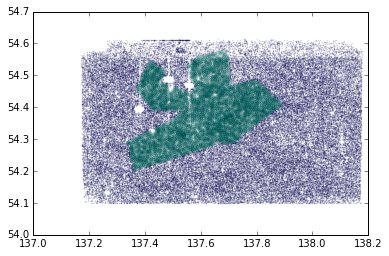

In [34]:
#Perform several shifts to data based on physical and statistical limits
#Apply several functions (defined in Cluster_funcs) for quality, magnitude cuts
#Then apply custom mask using point in poly function (in Cluster_funcs) to 
#identify objects inside and outside the area of best telescopic coverage
czmin,czmax=1.09,1.12
z=(1.12-1.09)/2+1.09
zsig=0.035 
#cat_all['z_peak_noshift']=cat_all.z_peak #Note this already stored during first iteration so uncommented
delz=0.0041 #This is an additional shift for our cluster after we applied the mean shift
#cat_all.z_peak=(cat_all.z_peak + (delz* (1+cat_all.z_spec)))
#Brian says use delz=0.0041, apply to peaks and and pzmin and max
cat_all['z_peak_shift']=(cat_all.z_peak + (delz* (1+cat_all.z_peak)))
cat_all['z_peak']=cat_all['z_peak_shift']
pzmax=czmax+1.*zsig*(1+czmax) + (delz* (1+z))#probably should compare completeness for 1.5 and 2*sigma
pzmin=czmin-1.*zsig*(1+czmin) + (delz* (1+z))#
pzmax2=czmax+2.*zsig*(1+czmax) + (delz* (1+z))#probably should compare completeness for 1.5 and 2*sigma
pzmin2=czmin-2.*zsig*(1+czmin) + (delz* (1+z))#
pzmax,pzmin = round(pzmax,2),round(pzmin,2)
pzmax2,pzmin2 = round(pzmax2,2),round(pzmin2,2)
#Quality cut based on definition from some functions I wrote in another file
cat_all = t.qcut(cat_all)
cat_all = t.zcut_PG(cat_all ,czmin, czmax, pzmin, pzmax,pzmin2, pzmax2,zcol='redshift') #this does photoz cut too
magh, magl = 23.25, 17 
#Magnitude cut
cat_all = t.mcut(cat_all, magh, magl) 
f='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/region_stuff/contPG.pickle'
cont=pd.read_pickle(f)
grouped=cont.groupby(level=0)
cat_all.id=cat_all.id.astype('int')
cat_all.set_index('id',drop=False,inplace=True)
cat_all['alpha']=cat_all.ra
cat_all['delta']=cat_all.dec
#Point and poly plotting based on pre-made mask of irregular shape that traces useable data
PG_slitmasks=grouped.apply(t.ppoly,cat_all[['id','alpha','delta']])
cat_all=t.reg_contour_PG(cat_all,PG_slitmasks)
py.plot(cat_all[cat_all.region_PG.notnull()].ra,cat_all[cat_all.region_PG.notnull()].dec,'co',ms=2,alpha=0.1)
py.plot(cat_all[cat_all.region_PG.isnull()].ra,cat_all[cat_all.region_PG.isnull()].dec,'bo',ms=1,alpha=0.1)
#Plot is after I've applied a mask using the point in poly function 

In [50]:
#Deal with irregular values that will mess up calculations down the road
cat_all.R.loc[(cat_all.R<0)]=np.nan
cat_all.I.loc[(cat_all.I<0)]=np.nan
cat_all.Z.loc[(cat_all.Z<0)]=np.nan
cat_all.I=cat_all.I.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_all.R=cat_all.R.replace([np.inf, '-99',-99], np.nan)
cat_all.Z=cat_all.Z.replace([np.inf, '-99',-99], np.nan)
cat_all.IZ=cat_all.IZ.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_all.RZ=cat_all.RZ.replace([np.inf, '-99',-99], np.nan)
cat_all.RI=cat_all.RI.replace([np.inf, '-99',-99], np.nan)
#Save cat with NIR wavelength data added
#cat_all.to_csv('cat_all_PG_NIR.tab',sep='\t',index=False,na_rep='NULL')
cat_all.set_index(['z_group','q_group'],drop=False, inplace=True)
print cat_all.xs(['cz'],level=['z_group']).groupby('q_group').size()
print cat_all[cat_all.I.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()
print cat_all[cat_all.R.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()
print cat_all[cat_all.Z.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()
cat_all[cat_all.R<0].xs(['cz'],level=['z_group'])[['R','I','Z','q_group']].groupby('q_group').size()
cat_all[(cat_all.R<0)|(cat_all.I<0)|(cat_all.Z<0)] #1722 phot and 3 spec have negative values
cat_all.R.loc[(cat_all.R<0)]=np.nan
cat_all.I.loc[(cat_all.I<0)]=np.nan
cat_all.Z.loc[(cat_all.Z<0)]=np.nan
onenull=(cat_all.R.isnull()|cat_all.I.isnull()|cat_all.Z.isnull())
print cat_all[onenull].groupby(['q_group','z_group']).size()
#print cat_all[onenull].
cond=cat_all.I.notnull()&cat_all.R.notnull()&cat_all.Z.notnull()
print cat_all[cond].groupby(['q_group','z_group']).size()

q_group
high    102
low       7
dtype: int64
q_group
high    98
low      7
dtype: int64
q_group
high    98
low      7
dtype: int64
q_group
high    99
low      7
dtype: int64
With at least one null (cannot use in CMD):
q_group  z_group
high     cz          4
         nz         24
low      nz         16
star     nz         35
dtype: int64
With at all not null (can use in CMD):
q_group  z_group
high     cz          98
         nz         576
low      cz           7
         nz         218
star     nz          13
dtype: int64
RIZ notnull in cz with hq: 4 total objects, null in I&R, 3 in Z


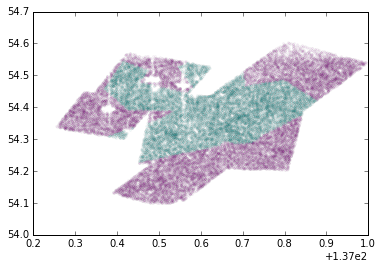

In [36]:
#Now with SFR_UVIR data...
#Coverage looks even over entire field
cat_all.LIR=cat_all.LIR.replace([np.inf, '-99',-99], np.nan)
PGnotnull=(cat_all.region_PG.notnull())
py.plot(cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.notnull())].ra,cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.notnull())].dec,'co',ms=2,alpha=0.05)
py.plot(cat_all[(cat_all.region_PG.isnull())&(cat_all.LIR.notnull())].ra,cat_all[(cat_all.region_PG.isnull())&(cat_all.LIR.notnull())].dec,'mo',ms=2,alpha=0.05)

In [39]:
c = 3*10**5 #Units km/s
z=zC=1.105
rvirB=1.01207064831
rvirA=0.820350458861
#rvir = r200/1.14
r200A=rvirA*1.14
r200B=rvirB*1.14
zCB= 1.1024208 #mean redshift B
zCA= 1.1003972 #mean redshift A
sigmaA, sigmaA_err=681.2,170.1
sigmaB, sigmaB_err=840.4,244.0
#CENTROIDS
#CENTROIDS XRAY
#09:10:44.91 +54:22:07.64
raA,decA=137.68712499999998,54.368788888888886
#09:10:08.77 +54:18:58.30
raB,decB=137.53654166666666,54.31619444444444
#raA,decA= 137.68400, 54.372387 #1mpc
#raB,decB= 137.51280, 54.309944 #1mpc
M200A, M200B = 2.91546371993e+14,5.47446715836e+14 #5.47446715836, 2.91546371993
cat_all.set_index(['id','z_group','q_group'],drop=False,inplace=True)
cat_gq=cat_all[cat_all.region_PG.notnull()] #remove photometric objects outside slitmask area for accurate completeness statistics
cat_gq['LFC_RA']=cat_gq.ra
cat_gq['LFC_dec']=cat_gq.dec
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
f=lambda a,b: tools.angdist(a,b,raA,decA)*60*60
fMpc=lambda a,b: tools.angdist(a,b,raA,decA)*60*cosmos.ProjectedLength(z)
cat_gq['dA']=map(f,cat_gq.LFC_RA,cat_gq.LFC_DEC)
cat_gq['dAMpc']=map(fMpc,cat_gq.LFC_RA,cat_gq.LFC_DEC)
f=lambda a,b: tools.angdist(a,b,raB,decB)*60*60
fMpc=lambda a,b: tools.angdist(a,b,raB,decB)*60*cosmos.ProjectedLength(z)
cat_gq['dB']=map(f,cat_gq.LFC_RA,cat_gq.LFC_DEC)
cat_gq['dBMpc']=map(fMpc,cat_gq.LFC_RA,cat_gq.LFC_DEC)
#blah=py.hist(cat_gq.dAMpc[cat_gq.dAMpc<2*rvirA],bins=10)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

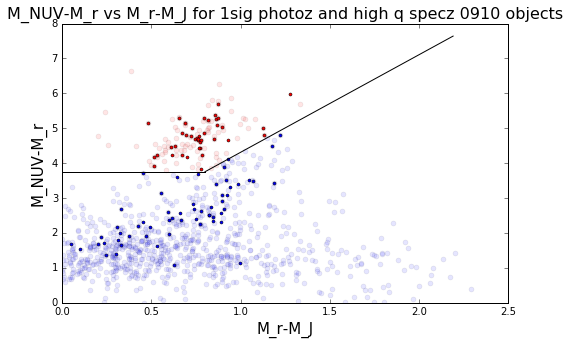

In [40]:
#INCLUDE ACTIVE PASSIVE DIVIDE HERE
#COPIED FROM ROTATE_NUVRRJ. 
#I couldn't read this in because need to do 2 sigma cut for LTIR analysis 
cat_gq.set_index(['id'],drop=False,inplace=True)
#cat_gq.set_index(['id','z_group','q_group'],drop=False,inplace=True)
#-2.5 * log10( flux ) + 25
DM=43.5250505050505 #mean DM for LSS hq objects
zp=25.0
f=lambda x: - 2.5*np.log10(x) - DM + zp
cat_gq['M_NUV']=map(f,cat_gq['restflux_NUV'])
cat_gq['M_r']=map(f,cat_gq['restflux_r'])
cat_gq['M_J']=map(f,cat_gq['restflux_J'])
cat_gq['MNUVMr']=cat_gq['M_NUV']-cat_gq['M_r'] #y
cat_gq['MrMJ']=cat_gq['M_r']-cat_gq['M_J'] #x
cat_gq['gtype']=pd.Series(np.repeat(np.array(['active']),len(cat_gq)), index=cat_gq.index)
m,y0=2.8,1.51
x_cut=0.8 #MRMJ cut for quiescence: gt has linear y cut, leq has linear cut 
y_cut=3.75
f = lambda y, x : y - x * m #substract slope from each point based on x value
cat_gq['MNUVMr_mod'] = map(f , cat_gq['MNUVMr'], cat_gq['MrMJ'])
#py.plot(cat_gq['M_r']-cat_gq['M_J'] ,cat_gq['M_NUV']-cat_gq['M_r'],'bo',ms=3,alpha=0.1)
#py.plot(cat_gq['MrMJ'] ,cat_gq['MNUVMr'],'ro',ms=1,alpha=0.2)
#py.savefig('MNURRRJ_all.png')
#cat_gq['MNUVMr_mod']=pd.Series(np.repeat(np.array(['np.nan']),len(cat_gq)), index=cat_gq.index)
#mpld3.enable_notebook()
py.rcParams['figure.figsize'] = (8, 5)
#%pylab inline
criterion1 = cat_gq['MNUVMr_mod'].map(lambda x: x>=y0) # gt y0 for gt 0.8 
criterion2 = cat_gq['MrMJ'].map(lambda x: x>x_cut) # gt 0.8 
criterion3 = cat_gq['MNUVMr'].map(lambda x: x>=y_cut) # gt y_cut for 
criterion4 = cat_gq['MrMJ'].map(lambda x: x<=x_cut) #lteq 0.8  geq
cat_gq.loc[criterion1&criterion2,'gtype']='quiescent'
cat_gq.loc[criterion3&criterion4,'gtype']='quiescent'
#cat_gq.to_csv('cat_gq_test_NUVRRJ.tab',sep='\t',index=False)
cat_gq.set_index(['id','z_group','z_group_pz','q_group','gtype'],drop=False,inplace=True)
#cat_gq.groupby(['q_group','z_group','gtype']).size()
py.plot(cat_gq.xs(['active','pz'],level=['gtype','z_group_pz']).MrMJ, cat_gq.xs(['active','pz'],level=['gtype','z_group_pz']).MNUVMr,'bo',ms=5,alpha=.1)
py.plot(cat_gq.xs(['quiescent','pz'],level=['gtype','z_group_pz']).MrMJ, cat_gq.xs(['quiescent','pz'],level=['gtype','z_group_pz']).MNUVMr,'ro',ms=5,alpha=.1)
py.plot(cat_gq.xs(['active','cz','high'],level=['gtype','z_group','q_group']).MrMJ, cat_gq.xs(['active','cz','high'],level=['gtype','z_group','q_group']).MNUVMr,'bo',ms=3,alpha=1)
py.plot(cat_gq.xs(['quiescent','cz','high'],level=['gtype','z_group','q_group']).MrMJ, cat_gq.xs(['quiescent','cz','high'],level=['gtype','z_group','q_group']).MNUVMr,'ro',ms=3,alpha=1)
#py.plot(cat_gq.xs(['active'],level=['gtype']).MrMJ, cat_gq.xs(['active'],level=['gtype']).MNUVMr,'bo',ms=2,alpha=.3)
#py.plot(cat_gq.xs(['quiescent'],level=['gtype']).MrMJ, cat_gq.xs(['quiescent'],level=['gtype']).MNUVMr,'ro',ms=5,alpha=.3)
#py.xlim([0,2])
#py.ylim([0,8])
x=np.arange(0.8,2.2,.01)
y=y0+2.8*x #1.51 is intercept, m is slope
py.plot(x,y,'k-') # line starting at x=0.8 increasing to inf 
#y=np.arange(0,3.75,.01)
#x=y*0.0+x_cut
#py.plot(x,y,'k--') #plots constant x line of 0.8 dividing slopes
x=np.arange(0,x_cut+0.01,.01)
y=y_cut+x*0.0 #3.75
py.plot(x,y,'k-') #plots constant y line, should stop at x_cut
py.xlim([0,2.5])
py.ylim([0,8])
py.ylabel('M_NUV-M_r',fontsize=15)
py.xlabel('M_r-M_J',fontsize=15)
py.title('M_NUV-M_r vs M_r-M_J for 1sig photoz and high q specz 0910 objects',fontsize=16)
#py.ylabel(r'$M_{NUV}-M_{r}$',fontsize=20)
#py.xlabel(r'$M_{r}-M_{J}$',fontsize=20)
#py.savefig('MNURRRJ_pzczhq.png')


In [41]:
#Do binning to assign each object to a region, the original analysis and justification for bins was in the rotate notebook
#folder='Rvir_radialg4'
folder='Rvir_radialg4_NUVRRJ'
targetdir='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/'+folder+'/'

core_condA, core_condB=(cat_gq.dAMpc<0.5*rvirA),(cat_gq.dBMpc<0.5*rvirB)
annulus_condA,annulus_condB=((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)
print 'This will not work if I have index of id because there are duplicates...I think groupby keeps index'
cat_gq.reset_index(inplace=True,drop=True)
labels=['merger back','infall B','core B','merger front','infall A','core A'] #conpare 1+13 to see how diff they are
bins3=['1','2','3','4','5','6'] #This is to assign new bin numbers for coadd program if don't want to use string names
#bins2=[['1','13'],['2','3','4','5','6'],['2','3','4','5','6'],['7'],['8','9','10','11','12'],['8','9','10','11','12'] ]
colors=['bo','ro','co','go','mo','yo']
#Use dict to toggle between selecting regions based on index and string name for iteration
dic=dict(zip(labels, bins3)) 

#REV3 EDIT: NEW BIN FOR MERGER FRONT AND MERGER BACK APPROX
cat_gq.loc[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i34']='merger front 3p5'
#cat_gq.loc[((cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ),'slice_i2']=
#MFX=3.5
MFX=4.0
#NEW definition of MERGER BACK, removed above linear string assignment for slice
#Objects within 4*Rvir but greater than 1.5*Rvir (annulus same as merger front, but NOT in merger front)
cat_gq.loc[( ((cat_gq.dBMpc<=MFX*rvirB)&(cat_gq.dBMpc>1.5*rvirB)) | ((cat_gq.dAMpc<=MFX*rvirA)&(cat_gq.dAMpc>1.5*rvirA)) ),'slice']='merger back'
cat_gq.loc[( ((cat_gq.dBMpc<=MFX*rvirB)&(cat_gq.dBMpc>1.5*rvirB)) | ((cat_gq.dAMpc<=MFX*rvirA)&(cat_gq.dAMpc>1.5*rvirA)) ),'slice_i2']=dic['merger back']
cat_gq.loc[( (cat_gq.dBMpc<=MFX*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=MFX*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice']='merger front'
cat_gq.loc[( (cat_gq.dAMpc<=MFX*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=MFX*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ),'slice_i2']=dic['merger front']
#variation to see how membership changes with 3 to 4 Mpc radii
cat_gq.loc[(~( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ) ) & ( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i34']='merger front 3_4'
#cat_gq.loc[(~( (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ) ) & ( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i2']=dic['merger front']
cat_gq.loc[((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)),'slice']='infall B'
cat_gq.loc[((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),'slice']='infall A'
cat_gq.loc[(cat_gq.dBMpc<0.5*rvirB),['slice']]='core B'
cat_gq.loc[(cat_gq.dAMpc<0.5*rvirA),['slice']]='core A'
cat_gq.loc[((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)),'slice_i2']=dic['infall B']
cat_gq.loc[((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),'slice_i2']=dic['infall A']
cat_gq.loc[(cat_gq.dBMpc<0.5*rvirB),['slice_i2']]=dic['core B']
cat_gq.loc[(cat_gq.dAMpc<0.5*rvirA),['slice_i2']]=dic['core A']
print cat_gq.groupby('slice').size()

This will not wor if I have index of id because there are duplicates...I think groupby keeps index
slice
core A           156
core B           188
infall A        1011
infall B        1360
merger back     7725
merger front    2049
dtype: int64


using dic (zip of bins3 and labels manually spec), will not plot unassigned {'infall B': '2', 'infall A': '5', 'core B': '3', 'core A': '6', 'merger back': '1', 'merger front': '4'}
plotting merger back 1
plotting infall B 2
plotting core B 3
plotting merger front 4
plotting infall A 5
plotting core A 6
1 ['1'] ['merger back'] 28
2 ['2'] ['infall B'] 18
3 ['3'] ['core B'] 9
4 ['4'] ['merger front'] 19
5 ['5'] ['infall A'] 17
6 ['6'] ['core A'] 8


1 ['1'] ['merger back'] 8
2 ['2'] ['infall B'] 17
3 ['3'] ['core B'] 9
4 ['4'] ['merger front'] 18
5 ['5'] ['infall A'] 16
6 ['6'] ['core A'] 8
41227335077.9
merger front mean 48491920611.1
merger back mean 2.802400125e+11
merger front median 13363650000.0
merger back median 85611450000.0


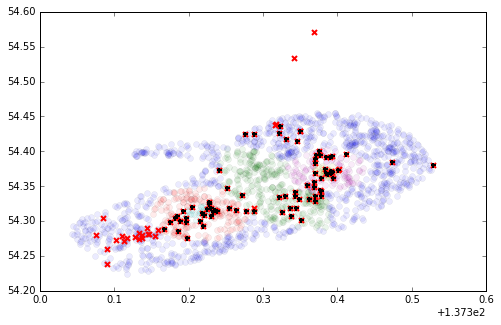

In [45]:
#Checking numbers after cuts
#mpld3.enable_notebook()
#cat_gq=cat_gq[(cat_gq.Z<=23.25)&(cat_gq.Z>=20.0)]
mag=((cat_gq.Z<=23.25)&(cat_gq.Z>=20.0))
#t.cont_plot(grouped,False)
sn2=((cat_gq.ftot_mips24/cat_gq.etot_mips24)>2.0)
#cat_gq.set_index(['z_group','q_group','z_group_pz'],drop=False,inplace=True)
cat_gq.set_index(['z_group','q_group','slice','z_group_pz','z_group_pz2'],drop=False,inplace=True)

print 'using dic (zip of bins3 and labels manually spec), will not plot unassigned',dic
#Still have to replace tis loop with inverse dic zip(colors,labels): for num in nums: print dic[num],num
for a,b,c in zip(labels,colors,bins3): #THIS WONT PLOT UNASSIGNED (which has tons/all of the un assigned photoz gals)  
    print 'plotting',a,c
    py.plot(cat_gq[(cat_gq.slice==a)&(cat_gq.Z<=23.25)].ra,cat_gq[(cat_gq.slice==a) &(cat_gq.Z<=23.25)].dec,b,ms=6,alpha=0.08) #Why so few now
for a,b in cat_gq.xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()
print '\n'
#py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=3,mew=5)
for a,b in cat_gq[(cat_gq.LIR.notnull())].xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()
py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=5,mew=2)
py.plot(cat_gq[(cat_gq.LIR.notnull())].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[(cat_gq.LIR.notnull())].xs(['high','cz'],level=['q_group','z_group']).dec,'k+',ms=5,mew=2)
print cat_gq[cat_gq.LIR.notnull()].xs(['high','cz'],level=['q_group','z_group']).LIR.mean()
#print 'merger front mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).SFR_UVIR.values
#print 'merger back mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).SFR_UVIR.values

print 'merger front mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).LIR.mean()
print 'merger back mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).LIR.mean()
print 'merger front median',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).LIR.median()
print 'merger back median',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).LIR.median()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Errors using fractional I think, have to check back with Adam vs Brian methods:
23173656761.2 13828684137.2
12
sqrt(err^2 summed)*1.253/N 11468782264.0
sqrt(err^2 summed)*1.253/N 1.1668819164
MF_LIR_err_mean*1.253/N 0.852834223379
MF_LIR_err_median*1.253/N 0.508921626744

MB: (Just the error on median L_TIR)
33981747212.9 23345647508.5
37
MB sqrt(err^2 summed)*1.253/N 8530066261.64
sqrt(err^2 summed)*1.253/N 0.867884648713

MB_LIR_err_mean*1.253/N 0.712205815585
MB_LIR_err_median*1.253/N 0.489289318174
MF median converted to SFR 11.2289055233
MB median converted to SFR 14.6547238372
MF median 1.103641e+11
MB median 1.44035e+11
MF TAIL (nan, nan, pz)    5.355260e+10
(nan, nan, nz)    6.590000e+10
(nan, nan, nz)    7.562410e+10
(nan, nan, pz)    1.358450e+11
(nan, nan, pz)    1.889680e+11
Name: LIR, dtype: float64
MB TAIL (nan, nan, nz)    3.746610e+10
(nan, nan, nz)    3.891510e+10
(nan, nan, nz)    3.969280e+10
(nan, nan, pz)    5.135650e+10
(nan, nan, nz)    5.733450e+10
Name: LIR, dt

"\nprint '\nOnly apply this with high S/N, so uncomment low SN cut above, and depth cut'\nprint 'DROPPING for XRAY (1 and 6 to get to 65711000000.0 or 6.57e10) high SN for equal depth'\nprint 'MF med',np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna())[1:].median()\nprint 'MB med',np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna())[6:].median()\n#print '\nMF min',sort(np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()))[1:].count()\n#print 'MB min',sort(np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna()))[3:].count()\n#print 'MF median',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].median()\n#print 'MB median',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].median()\nprint 'MF mean',pd.concat([MF2sig,MFhq]).LIR.dropna()[1:].mean()\nprint 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].mean()\nprint 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna()[1:].count()\nprint 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].count()\nprint 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR[1:].dropna().count()/MFSA*(

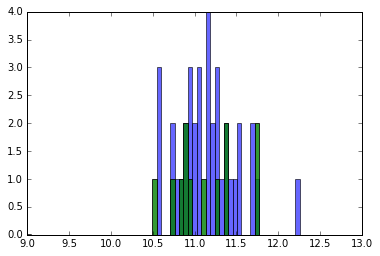

In [48]:
'''
#Below is from the LIR analysis we added after getting L_TIR data.
This is important because a lot of UV starlight is locked up in dust and re-radiated in the IR
We originally estimated this contribution based on ratios of measureable emission lines in spec data
We have to do several forms of analysis to insure the new data is consistent with our current results 
We must first confirm the data across our field of of equal depth
Then confirm using signal-to-noise and magnitude cuts that we have not missed a large population of starbursting galaxies
Then confirm the average L_TIR of all sources between the two regions is consistent with our other measures 
I did this by un/commenting out large blocks to toggle signal-to-noise cuts and equal depth corrections
'''
#from scipy.stats import ks_2samp,kstest
#mpld3.enable_notebook()
cat_gq.set_index(['z_group','q_group','slice','z_group_pz','z_group_pz2'],drop=False,inplace=True)

#Area of each region measured from DS9 contours for Optical and Xray centroids
MFSA=91336.5
MBSA=267126.0
#MFSA=77568.8
#MBSA=288449.0

#MF2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger front'],level=['z_group_pz2','slice'])
#MFhq=cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger front','high'],level=['z_group','slice','q_group'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger back'],level=['z_group_pz2','slice'])
#MBhq=cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger back','high'],level=['z_group','slice','q_group'])

#np.log(cat_gq)
#With SN cut and mag cut
MF2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger front'],level=['z_group_pz2','slice']).sort_values(['LIR'])
MFhq=cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger front','high'],level=['z_group','slice','q_group']).sort_values(['LIR'])
MB2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger back'],level=['z_group_pz2','slice']).sort_values(['LIR'])
MBhq=cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger back','high'],level=['z_group','slice','q_group']).sort_values(['LIR'])

#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(2.3)]
#MFhq=MFhq[MFhq.ftot_mips24>=10**(2.3)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(2.3)]
#MBhq=MBhq[MBhq.ftot_mips24>=10**(2.3)]
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.9)]
#MFhq=MFhq[MFhq.ftot_mips24>=10**(1.9)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.9)]
#MBhq=MBhq[MBhq.ftot_mips24>=10**(1.9)]

#L_TIR DEPTH
%pylab inline
n,binss,patches=py.hist(np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna()),bins=75,alpha=0.6,range=[9,13])
py.hist(np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()),bins=binss,alpha=0.8)
#n,binss,patches=py.hist(pd.concat([MB2sig,MBhq]).LIR.dropna(),bins=25,alpha=0.6)
#py.hist(pd.concat([MF2sig,MFhq]).LIR.dropna(),bins=binss,alpha=0.8)
#py.savefig('LTIRdepthhist.png')
'''
print 'WITH S/N>2 CUT'
print 'MF median',pd.concat([MF2sig,MFhq]).LIR.dropna().median()
print 'MB median',pd.concat([MB2sig,MBhq]).LIR.dropna().median()
print 'MF median SFR_UVIR',pd.concat([MF2sig,MFhq]).SFR_UVIR.dropna().median()
print 'MB median SFR_UVIR',pd.concat([MB2sig,MBhq]).SFR_UVIR.dropna().median()
print 'MF mean',pd.concat([MF2sig,MFhq]).LIR.dropna().mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna().mean()
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna().count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna().count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR.dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR.dropna().count()/MBSA*(60**2)
'''
#flux_24 / error_24 = L_TIR / error_L_TIR
#sn2=((cat_gq.ftot_mips24/cat_gq.etot_mips24)>2.0)
#cat_gq['LIR_err']=cat_gq.LIR / (cat_gq.ftot_mips24/cat_gq.etot_mips24)
#py.hist((cat_gq.ftot_mips24/cat_gq.etot_mips24).dropna())
#print (cat_gq['LIR_err']/cat_gq['LIR_err']).describe()
#Now add LIR errors in quad by squaring a column then summing then taking sqrt
#cat_gq['LIR_err2']=cat_gq['LIR_err'].apply(lambda x: pow(x,2).sum())
#cat_gq['LIR_err2']=cat_gq['LIR_err']*cat_gq['LIR_err']
#Add all uncertainties of the L_TIR values which go into each distribution (separately) in quadrature, divide by sqrt(N_gal), and multiply by 1.253
#print cat_gq['LIR_err'].dropna().T
#print np.sqrt( cat_gq['LIR_err2'].sum() )

'''
print '\nWITHOUT S/N>2 CUT'
MF2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag].xs(['pz','merger front'],level=['z_group_pz2','slice'])
MFhq=cat_gq[(cat_gq.LIR.notnull())&mag].xs(['cz','merger front','high'],level=['z_group','slice','q_group'])
MB2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag].xs(['pz','merger back'],level=['z_group_pz2','slice'])
MBhq=cat_gq[(cat_gq.LIR.notnull())&mag].xs(['cz','merger back','high'],level=['z_group','slice','q_group'])
'''

#print pd.concat([MF2sig,MFhq])['LIR_err'].dropna().T
#print MFhq['LIR_err'].dropna().T
#print np.sqrt( pd.concat([MF2sig,MFhq])['LIR_err2'].sum() )
#flux_24 / error_24 = L_TIR / error_L_TIR
#sn2=((cat_gq.ftot_mips24/cat_gq.etot_mips24)>2.0)
#cat_gq['LIR_err']=cat_gq.LIR / (cat_gq.ftot_mips24/cat_gq.etot_mips24)
#py.hist((cat_gq.ftot_mips24/cat_gq.etot_mips24).dropna())
#print (cat_gq['LIR_err']/cat_gq['LIR_err']).describe()
MF=pd.concat([MF2sig,MFhq]).reset_index()
MB=pd.concat([MB2sig,MBhq]).reset_index()
#MF[['id_phot','LIR','ftot_mips24','etot_mips24']].to_csv('MF_LTIR.tab',sep='\t',index=False)
#MB[['id_phot','LIR','ftot_mips24','etot_mips24']].to_csv('MB_LTIR.tab',sep='\t',index=False)
MF['LIR_err']=MF.LIR / (MF.ftot_mips24/MF.etot_mips24) #Make uncertainty
MF_LIR_err_mean=(MF.LIR/(MF.ftot_mips24/MF.etot_mips24)).mean()
#Adam's error requires mean(f24err/f24*LTIR)/sqrt(n_elements(ID))
MF_LIR_err_median=(MF.LIR/(MF.ftot_mips24/MF.etot_mips24)).median()
print 'Errors using fractional I think, have to check back with Adam vs Brian methods:'
print MF_LIR_err_mean,MF_LIR_err_median

MF['frac']=MF.etot_mips24/MF.ftot_mips24
MF['LIR_err2']=MF['LIR_err']*MF['LIR_err'] #Square so can add in quad then sqrt
print MF['LIR_err2'].count()
#print np.sqrt(MF['LIR_err2'].count()) #divide by sqrt(N)
#print '1.253/sqrt(N)',1.253/np.sqrt(MF['LIR_err2'].count()) #divide by sqrt(N) *1.253
#print 'sqrt(err^2 summed)*1.253/sqrt(N)',np.sqrt(MF['LIR_err2'].sum())*1.253/np.sqrt(MF['LIR_err2'].count()) 
#print 'sqrt(err^2 summed)*1.253/sqrt(N)',(np.sqrt(MF['LIR_err2'].sum())*1.253/np.sqrt(MF['LIR_err2'].count()))*(1.75e-10/1.72)
print 'sqrt(err^2 summed)*1.253/N',np.sqrt(MF['LIR_err2'].sum())*1.253/len(MF['LIR_err2']) 
print 'sqrt(err^2 summed)*1.253/N',np.sqrt(MF['LIR_err2'].sum())*1.253/len(MF['LIR_err2'])*(1.75e-10/1.72)
print 'MF_LIR_err_mean*1.253/N',MF_LIR_err_mean*1.253/np.sqrt(len(MF['LIR_err2']))*(1.75e-10/1.72)
print 'MF_LIR_err_median*1.253/N',MF_LIR_err_median*1.253/np.sqrt(len(MF['LIR_err2']))*(1.75e-10/1.72)

print '\nMB: (Just the error on median L_TIR)'
MB['LIR_err']=MB.LIR / (MB.ftot_mips24/MB.etot_mips24) #Make uncertainty
MB['frac']=MB.etot_mips24/MB.ftot_mips24
MB_LIR_err_mean=(MB.LIR/(MB.ftot_mips24/MB.etot_mips24)).mean()
#Adam's error requires mean(f24err/f24*LTIR)/sqrt(n_elements(ID))
MB_LIR_err_median=(MB.LIR/(MB.ftot_mips24/MB.etot_mips24)).median()
print MB_LIR_err_mean,MB_LIR_err_median
MB['LIR_err2']=MB['LIR_err']*MB['LIR_err'] #Square so can add in quad then sqrt
print MB['LIR_err2'].count()
#print np.sqrt(MB['LIR_err2'].count()) #divide by sqrt(N)
#print '1.253/sqrt(N)',1.253/np.sqrt(MB['LIR_err2'].count()) #divide by sqrt(N) *1.253
#print 'sqrt(err^2 summed)*1.253/sqrt(N)',np.sqrt(MB['LIR_err2'].sum())*1.253/np.sqrt(MB['LIR_err2'].count()) 
#print 'sqrt(err^2 summed)*1.253/sqrt(N)',(np.sqrt(MB['LIR_err2'].sum())*1.253/np.sqrt(MB['LIR_err2'].count()))*(1.75e-10/1.72)
print 'MB sqrt(err^2 summed)*1.253/N',np.sqrt(MB['LIR_err2'].sum())*1.253/len(MB['LIR_err2'])
print 'sqrt(err^2 summed)*1.253/N',np.sqrt(MB['LIR_err2'].sum())*1.253/len(MB['LIR_err2'])*(1.75e-10/1.72)
print '\nMB_LIR_err_mean*1.253/N',MB_LIR_err_mean*1.253/np.sqrt(len(MB['LIR_err2']))*(1.75e-10/1.72)
print 'MB_LIR_err_median*1.253/N',MB_LIR_err_median*1.253/np.sqrt(len(MB['LIR_err2']))*(1.75e-10/1.72)

'''
print MF.frac.head()
#MF.LIR/MF['LIR_err'].head()
print MF['LIR'].head()
print MF['LIR_err'].head()
MF['LIR_err2']=MF['LIR_err']*MF['LIR_err'] #Square so can add in quad then sqrt
print MF['LIR_err2'].head()
print MF['LIR_err2'].head().sum()
print np.sqrt(MF['LIR_err2'].head().sum())
print MF['LIR_err2'].head().count()
print np.sqrt(MF['LIR_err2'].head().count()) #divide by sqrt(N)
print '1.253/sqrt(N)',1.253/np.sqrt(MF['LIR_err2'].head().count()) #divide by sqrt(N) *1.253
#*(1.75e-10/1.72)
print '1.253/sqrt(N)',np.sqrt(MF['LIR_err2'].head().sum())*1.253/np.sqrt(MF['LIR_err2'].head().count()) 
'''
#print '\n',np.sqrt( pd.concat([MF2sig,MFhq])['LIR_err2'].sum() ) / np.sqrt( pd.concat([MF2sig,MFhq])['LIR_err2'].count())*1.253
#print MBhq['LIR_err'].dropna().T
#print np.sqrt( pd.concat([MB2sig,MBhq])['LIR_err2'].sum() )
#print np.sqrt( pd.concat([MB2sig,MBhq])['LIR_err2'].sum() )/np.sqrt( pd.concat([MB2sig,MBhq])['LIR_err2'].count())*1.253
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(2.3)]
#MFhq=MFhq[MFhq.ftot_mips24>=10**(2.3)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(2.3)]
#MBhq=MBhq[MBhq.ftot_mips24>=10**(2.3)]
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.9)]
#MFhq=MFhq[MFhq.ftot_mips24>=10**(1.9)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.9)]
#MBhq=MBhq[MBhq.ftot_mips24>=10**(1.9)]

print 'MF median converted to SFR',pd.concat([MF2sig,MFhq]).LIR.dropna().median()*(1.75e-10/1.72)
print 'MB median converted to SFR',pd.concat([MB2sig,MBhq]).LIR.dropna().median()*(1.75e-10/1.72)
print 'MF median',pd.concat([MF2sig,MFhq]).LIR.median()
print 'MB median',pd.concat([MB2sig,MBhq]).LIR.median()
#print 'MF TAIL',sort(pd.concat([MF2sig,MFhq]).LIR.dropna()).head()
#print 'MB TAIL',sort(pd.concat([MB2sig,MBhq]).LIR.dropna()).head()
print 'MF TAIL',pd.concat([MF2sig,MFhq]).LIR.dropna().head()
print 'MB TAIL',pd.concat([MB2sig,MBhq]).LIR.dropna().head()
print '\nMF mean (converted to Chabrier in Lsol)',pd.concat([MF2sig,MFhq]).LIR.dropna().mean()*(1.75e-10/1.72)
print 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna().mean()*(1.75e-10/1.72)
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna().count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna().count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR.dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR.dropna().count()/MBSA*(60**2)

#Last question, plot f_nu for all SN>2 objects in MF and MB
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(2.3)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(2.3)]
#print ks_2samp(MF2sig.ftot_mips24,MB2sig.ftot_mips24)
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger back'],level=['slice'])
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.0)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.0)]
#print ks_2samp(MF2sig.ftot_mips24,MB2sig.ftot_mips24)
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger back'],level=['slice'])
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.6)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.6)]
#print ks_2samp(MF2sig.ftot_mips24,MB2sig.ftot_mips24)
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger back'],level=['slice'])
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.8)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.8)]
#print ks_2samp(MF2sig.ftot_mips24,MB2sig.ftot_mips24)
#the LTIR not null removes all objects not covered by mips:
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&mag].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&mag].xs(['merger back'],level=['slice'])
#Remove null 
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&mag&(cat_gq.weight_mips24!=0)].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&mag&(cat_gq.weight_mips24!=0)].xs(['merger back'],level=['slice'])
'''
print 'Z cut, no redshift cut, no S/N cut: MF and MB'
#ftot_mips24 DEPTH
#n,binss,patches=py.hist(np.log10(MB2sig.etot_mips24.dropna()),bins=25,alpha=0.5)
#py.hist(np.log10(MF2sig.etot_mips24.dropna()),bins=binss,alpha=0.5)
n,binss,patches=py.hist(MB2sig.etot_mips24.dropna(),bins=50,alpha=0.5,range=[-0.01,500])
py.hist(MF2sig.etot_mips24.dropna(),bins=binss,alpha=0.5)
py.xlabel('etot_mips24',fontsize=20)
py.figure()
n,binss,patches=py.hist(MB2sig.ftot_mips24.dropna(),bins=50,alpha=0.5,range=[-0.01,600])
py.hist(MF2sig.ftot_mips24.dropna(),bins=binss,alpha=0.5)
py.xlabel('ftot_mips24',fontsize=20)
py.figure()
n,binss,patches=py.hist(MB2sig.weight_mips24.dropna(),bins=50,alpha=0.5,range=[-0.01,10])
py.hist(MF2sig.weight_mips24.dropna(),bins=binss,alpha=0.5)
py.xlabel('weight_mips24',fontsize=20)
'''
#print 'MF median',MF2sig.weight_mips24.median()
#print 'MB median',MB2sig.weight_mips24.median()
#n,binss,patches=py.hist(pd.concat([MF2sig,MFhq]).weight_mips24.dropna(),bins=25,alpha=0.5)
#py.hist(pd.concat([MB2sig,MBhq]).weight_mips24.dropna(),bins=binss,alpha=0.5)
#n,binss,patches=py.hist(MB2sig.weight_mips24.dropna(),bins=25,alpha=0.5)
#py.hist(MF2sig.weight_mips24.dropna(),bins=binss,alpha=0.5)

#Ali edit post ref comment trying with Xray centroids, uncommented to rerun with optical centroidsfig
#print 'DROPPING for Optical (2 and 6 to get to 65711000000.0 or 6.57e10)'
#SORT before drop
print '\nMF med (log)',np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()).sort_values()[1:].median()
print 'MB med',np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna())[7:].sort_values().median()
print '\nMF med',pd.concat([MF2sig,MFhq]).LIR.dropna().sort_values()[1:].median()
print 'MB med',pd.concat([MB2sig,MBhq]).LIR.dropna().sort_values()[7:].median()
print 'MF mean Lsol',pd.concat([MF2sig,MFhq]).LIR.dropna().sort_values()[1:].mean()*(1.75e-10/1.72)
print 'MB mean Lsol',pd.concat([MB2sig,MBhq]).LIR.dropna().sort_values()[7:].mean()*(1.75e-10/1.72)
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna().sort_values()[1:].count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna().sort_values()[7:].count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR[1:].dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR[7:].dropna().count()/MBSA*(60**2)
print '\nMF mean (lmass)',pd.concat([MF2sig,MFhq]).lmass.dropna().sort_values()[1:].mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).lmass.dropna().sort_values()[7:].mean()
print '\nMF mean (lmass)',pd.concat([MF2sig,MFhq]).lmass.dropna().sort_values().mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).lmass.dropna().sort_values().mean()

'''
#Ali edit post ref comment, uncommented to rerun with Optical centroidsfig
print 'DROPPING for Optical (2 and 6 to get to 65711000000.0 or 6.57e10)'
print '\nMF med',np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna())[2:].median()
print 'MB med',np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna())[6:].median()
#print '\nMF min',sort(np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()))[1:].count()
#print 'MB min',sort(np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna()))[3:].count()
#print 'MF median',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].median()
#print 'MB median',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].median()
print 'MF mean',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].mean()
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR[2:].dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR[6:].dropna().count()/MBSA*(60**2)
'''

'''
print '\nOnly apply this with high S/N, so uncomment low SN cut above, and depth cut'
print 'DROPPING for XRAY (1 and 6 to get to 65711000000.0 or 6.57e10) high SN for equal depth'
print 'MF med',np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna())[1:].median()
print 'MB med',np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna())[6:].median()
#print '\nMF min',sort(np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()))[1:].count()
#print 'MB min',sort(np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna()))[3:].count()
#print 'MF median',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].median()
#print 'MB median',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].median()
print 'MF mean',pd.concat([MF2sig,MFhq]).LIR.dropna()[1:].mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].mean()
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna()[1:].count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR[1:].dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR[6:].dropna().count()/MBSA*(60**2)
'''

#print 'MF median',sort(pd.concat([MF2sig,MFhq]).LIR.dropna()).T
#print 'MB median',sort(pd.concat([MB2sig,MBhq]).LIR.dropna()).T
#We weight by sqrt 2 because the median exposure time is twice that of MF...sigma equals sqrt(N)...or two?
#So cutting object with LTIR below X, or reducing depth in MB by sqrt(2)1-1.4 
#py.show()
#py.savefig('blah_Xray')

In [64]:
#Above: We cut a few objects by forcing equal depth and still found that number density 

In [ ]:
#Some stuff with duplicates
#print cat_g[cat_g.nmatch==2]
#print blah[blah.id==38941][['I','magaper_Iplus','nmatch']]
#print blah[blah.id==39005][['I','magaper_Iplus','nmatch']]
#print cat_g[cat_g.nmatch==2]
# 53820,54163
#print blah[blah.id==53820][['I','magaper_Iplus','nmatch']]
#print blah[blah.id==54163][['I','magaper_Iplus','nmatch']]

#Check that scinot read in
#Check duplicates and int: read in slit as string, remove s make into separate column then make int
#There are only 5 duplicates.
#Two have the same id_spec=5878, one of which is a serendip, both q=4
#cat_g[cat_g.duplicated(['id_phot'])|cat_g.duplicated(['id_phot'],take_last=True)].id_phot
#cat_g[cat_g.duplicated(['id_phot'])|cat_g.duplicated(['id_phot'],take_last=True)][['id_spec','id_phot','maskname']]
#cat_g[cat_g.duplicated(['id_phot','slitmask'])|cat_g.duplicated(['id_phot','slitmask'],take_last=True)][['id_spec','id_phot','slitmask','nmatch','slitnum','blend']]
#Make these into two entries and manually assign one f the id_phots to each
#For example, 
#One of these objects is T08_LRIS which means we don't actually have spectrum but have specz redshift and catalog from T08 paper